## ДЗ к Урок 1. Введение в PyTorch

1. Добиться вразумительного результата от модели, собранной на занятии (3 угаданные картинки из 4 предложенных на семинаре). Варианты изменений:

    a. изменение слоёв и их количества;
    
    b. изменение метода оптимизации; 
    
    c. изменение процесса обучения; 
    
    d. для продвинутых: преобразование данных.

2. Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

3. Переписать эту программу на PyTorch:
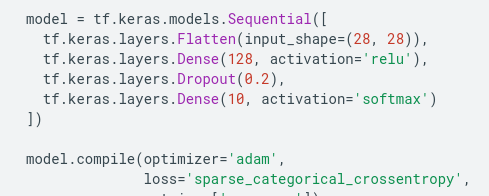
Не забудьте про реализацию функции forward! 

In [54]:
!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [55]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85


In [56]:
import torch
import torchvision

In [57]:
import numpy as np

In [59]:
x = np.arange(9).reshape(3, 3)

print("X :\n%s\n" % x)
print("X размеры : %s\n" % (x.shape,))
print("X тип : %s\n" % (type(x)))
# print("Добавим 10 :\n%s\n" % (x + 10))
# print("Среднее по строчке :\n%s\n" % (x.mean(axis=-1)))
# print("Среднее по столбцу :\n%s\n" % (x.mean(axis=0)))

X :
[[0 1 2]
 [3 4 5]
 [6 7 8]]

X размеры : (3, 3)

X тип : <class 'numpy.ndarray'>



##### PyTorch поддерживает разные типы тензоров:

* HalfTensor: 16-bit float
* FloatTensor: 32-bit float (torch.Tensor)
* DoubleTensor: 64-bit float

* ShortTensor: 16-bit int
* IntTensor: 32-bit int
* LongTensor: 64-bit int



#####  Весь список:
* https://pytorch.org/docs/stable/tensors.html

##### Функция для вывода данных о тензоре:

In [60]:
def print_tens_info(tensor):
    print("X :\n%s\n" % tensor)
    print("X количество измерений:\n%s\n" % tensor.dim())
    print("X размеры : ",  tensor.size())
    print("X тип : %s\n" % (tensor.type()))
#     print("Добавим 10 :\n%s\n" % (tensor + 10))
#     print("Среднее по строчке :\n%s\n" % (tensor.mean(axis=-1)))
#     print("Среднее по столбцу :\n%s\n" % (tensor.mean(axis=0)))
    

In [74]:
# y = np.arange(9).reshape(3, 3).astype(float)
# x = torch.tensor(y)  
# x = torch.DoubleTensor(3, 3, 3)
x = torch.LongTensor([[1.0, 2.0],[2.0,3.0]])  

In [75]:
print_tens_info(x)

X :
tensor([[1, 2],
        [2, 3]])

X количество измерений:
2

X размеры :  torch.Size([2, 2])
X тип : torch.LongTensor



In [76]:
x = torch.arange(9).view(3,3) 
x = torch.arange(0,9).view(3,3).type(torch.float32)
# y = np.arange(9).reshape(3, 3).astype(float)

In [77]:
print_tens_info(x)

X :
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

X количество измерений:
2

X размеры :  torch.Size([3, 3])
X тип : torch.FloatTensor



#####  Из numpy в tensor и обратно

In [78]:
x = x.numpy()
print("X :\n%s\n" % x)
print("X размеры : %s\n" % (x.shape,))
print("X тип : %s\n" % (type(x)))
# print("Добавим 10 :\n%s\n" % (x + 10))
# print("Среднее по строчке :\n%s\n" % (x.mean(axis=-1)))
# print("Среднее по столбцу :\n%s\n" % (x.mean(axis=0)))

X :
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]

X размеры : (3, 3)

X тип : <class 'numpy.ndarray'>



In [79]:
x = torch.randn(3, 3)
print_tens_info(x)

X :
tensor([[ 0.6482, -0.3881,  0.1024],
        [-1.0829,  1.7242, -0.3081],
        [ 1.1604,  0.6551,  1.5915]])

X количество измерений:
2

X размеры :  torch.Size([3, 3])
X тип : torch.FloatTensor



#####  Некоторые отличия:

* ```x.astype('int64') -> x.type(torch.LongTensor)```
* ``` np.concatenate ->	torch.cat ```
* ``` np.multiply ->	torch.cmul ```
* ``` np.copy(x) ->	x:clone() ```


### Градиент

$$a = (b + c)*(c + 2) $$
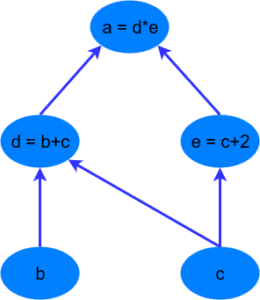

In [13]:
from torch.autograd import Variable

In [80]:
torch.ones(3)

tensor([1., 1., 1.])

In [82]:
x = Variable(torch.ones(3), requires_grad = True)

#### requires_grad 
Флаг, что необходимо автоматически вычислять градиент на тензоре при вызове функции .backward(). Если стоит False - градиент не нужен, обучение не происходит. 
Пример:

In [83]:
print_tens_info(x)

X :
tensor([1., 1., 1.], requires_grad=True)

X количество измерений:
1

X размеры :  torch.Size([3])
X тип : torch.FloatTensor



In [84]:
print(x.grad)

None


In [85]:
z = (x * x) + 5.0 * x #задание - посчитать производную ручками

In [89]:
print_tens_info(z)

X :
tensor([6., 6., 6.], grad_fn=<AddBackward0>)

X количество измерений:
1

X размеры :  torch.Size([3])
X тип : torch.FloatTensor



In [86]:
z.backward(torch.ones(3))

In [87]:
print(x.grad)

tensor([7., 7., 7.])


#### Подключаемые модули

In [21]:
from torch import nn 
from torch import optim

* nn - формирование вычислительных графов для слоев нейронных сетей. TensorFlow: Keras.
* optim - алгоритмы оптимизации (SGD, Adam и т.д.). TensorFlow: модуль optimizers.
* Dataset – представление входных и выходных данных в разных форматах: TensorDataset, IterableDataset)
* DataLoader преобразует Dataset в формат, с помощью которого можно контролировать размера пакета (batch size), перемешивать данные, распределять процессы и т.д. В TensorFlow за это отвечает модуль data.

In [90]:
linear = nn.Linear(2, 2)

In [91]:
print ('w: ', linear.weight)
print ('b: ', linear.bias)

w:  Parameter containing:
tensor([[-0.1135,  0.1813],
        [ 0.3234,  0.6520]], requires_grad=True)
b:  Parameter containing:
tensor([0.5534, 0.2229], requires_grad=True)


In [92]:
criterion = nn.MSELoss()

In [93]:
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

In [94]:
x = Variable(torch.randn(2), requires_grad = True)
y = Variable(torch.randn(2), requires_grad = False)

In [95]:
optimizer.zero_grad()
pred = linear(x)
loss = criterion(pred, y)
print('loss: ', loss.item())

loss:  2.687652587890625


In [96]:
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

dL/dw:  None
dL/db:  None


In [97]:
loss.backward()

In [98]:
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

dL/dw:  tensor([[ 1.9938, -1.6598],
        [-2.6913,  2.2405]])
dL/db:  tensor([ 1.3801, -1.8629])


In [31]:
print ('w: ', linear.weight)
print ('b: ', linear.bias)

w:  Parameter containing:
tensor([[ 0.2045, -0.4792],
        [ 0.1043,  0.1117]], requires_grad=True)
b:  Parameter containing:
tensor([-0.0256, -0.0523], requires_grad=True)


In [99]:
optimizer.step()

In [100]:
print ('w: ', linear.weight)
print ('b: ', linear.bias)

w:  Parameter containing:
tensor([[-0.1334,  0.1979],
        [ 0.3503,  0.6296]], requires_grad=True)
b:  Parameter containing:
tensor([0.5396, 0.2415], requires_grad=True)


#### Загрузка существующего датасета:

In [34]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

In [107]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=False)


image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


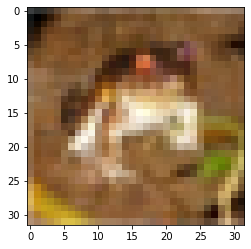

In [36]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [108]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [102]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [103]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Определим следующую модель:

In [112]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to('cpu')

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

[1,     1] loss: 0.001
[1,   301] loss: 0.345
[1,   601] loss: 0.345
[2,     1] loss: 0.001
[2,   301] loss: 0.345
[2,   601] loss: 0.345
[3,     1] loss: 0.001


#### Сохранение модели

In [43]:
PATH = './cifar_net_version_test_intro.pth'
torch.save(net.state_dict(), PATH)

In [53]:
print("Model state_dict: ")
for param in net.state_dict():
    print(param," \ ", net.state_dict()[param].size())

Model state_dict: 
conv1.weight  \  torch.Size([6, 3, 5, 5])
conv1.bias  \  torch.Size([6])
conv2.weight  \  torch.Size([16, 6, 5, 5])
conv2.bias  \  torch.Size([16])
fc1.weight  \  torch.Size([120, 400])
fc1.bias  \  torch.Size([120])
fc2.weight  \  torch.Size([84, 120])
fc2.bias  \  torch.Size([84])
fc3.weight  \  torch.Size([10, 84])
fc3.bias  \  torch.Size([10])


#### Загрузка и использование модели 

In [44]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [45]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:    cat  ship  ship plane


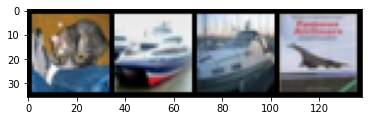

In [46]:
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [47]:
print(outputs)

tensor([[-1.0140, -0.4172,  0.7943,  1.7267, -0.3132,  1.6487,  1.0944, -1.3442,
          0.3265, -0.2044],
        [ 4.2120,  3.3777, -0.6366, -3.4576,  0.0717, -4.3322, -3.6657, -3.5366,
          5.7506,  2.9089],
        [ 2.1425,  3.7064, -1.0406, -2.0158, -1.0331, -2.6569, -2.5709, -2.9577,
          3.7213,  3.1935],
        [ 3.5605,  2.0153,  0.3879, -1.9209,  0.2129, -2.4324, -3.0770, -2.5827,
          4.7159,  0.6809]], grad_fn=<AddmmBackward>)


In [48]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


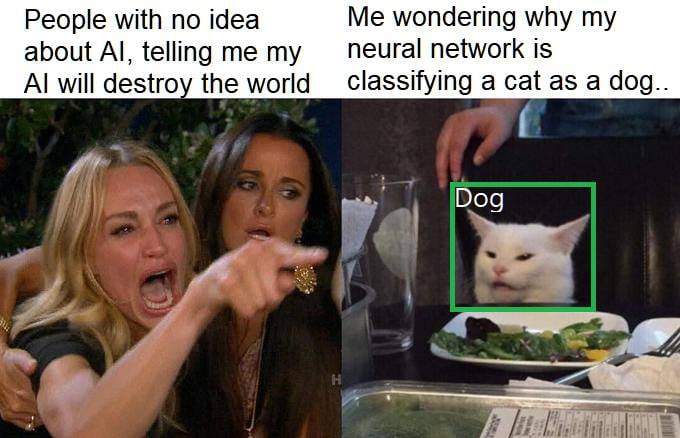

#### Подключение GPU 

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [50]:
torch.randn(10, 10, device=device)

tensor([[-1.1673e+00, -4.4547e-01,  1.0386e+00, -8.7516e-01, -3.5741e-01,
          8.5138e-01, -1.1577e+00,  1.3708e+00, -5.2753e-01, -5.3392e-01],
        [ 1.5675e-03, -3.4978e-01,  1.6073e+00, -1.7114e+00,  3.8542e-02,
          3.1676e-01,  4.4632e-01, -1.1929e+00,  5.2055e-03, -6.4465e-01],
        [ 1.4146e+00, -1.1439e-01,  1.2020e+00, -1.3957e-01, -1.9631e+00,
          2.6970e-01, -6.7097e-01, -1.0678e+00,  8.9411e-01,  5.5723e-01],
        [ 2.0426e-01,  1.3255e+00, -1.0611e+00, -3.0638e-01, -1.8725e-01,
          5.4164e-01, -8.1759e-01,  1.0486e-01,  9.1875e-03, -2.4288e+00],
        [-9.6765e-01, -1.0468e+00,  1.6859e-01,  1.0626e+00, -5.5881e-01,
          3.3930e-01, -1.7819e-01, -4.2448e-01, -1.3382e+00, -5.8529e-01],
        [ 1.2879e+00, -3.0908e-01,  5.6328e-01, -1.2010e+00,  1.4069e+00,
          4.3076e-01, -6.8986e-01,  1.5604e+00, -4.8704e-01, -2.0964e+00],
        [ 8.8558e-01, -4.8685e-01,  2.9001e-01,  1.5581e+00, -1.3618e+00,
          1.5163e+00,  6.4413e-0

In [51]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)